Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

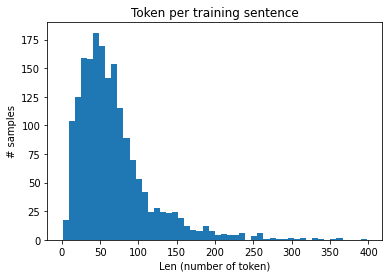

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

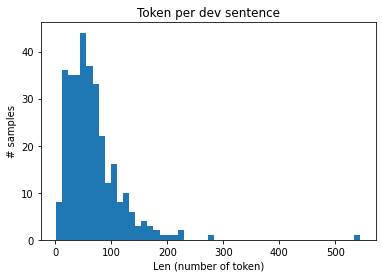

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

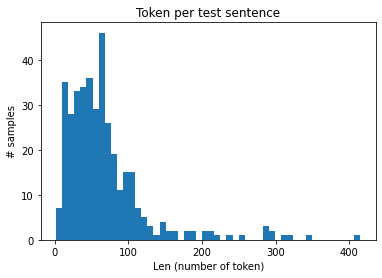

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

4197
Consta
1
I-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9174)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 1817
Points in y_train before removal: 1817


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[1064, 12743, 11813, 8981, 11009, 1987, 157, 9382, 7251, 12743, 2724, 8981, 2891, 13404, 2177, 8734, 3701, 2654, 2294, 2786, 2423, 13441, 2129, 8981, 11899, 3329, 13441, 9883, 5326, 12463, 8981, 12743, 12413, 8981, 4987, 12323, 13402, 8637, 2654, 8981, 11295, 1016, 13441, 8946, 8637, 10774, 9197, 8637, 6167, 8981, 239, 9577, 3946, 2294, 2561, 8637, 4021, 8713, 477, 1226, 2294, 3161, 13441, 4714, 3628]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[4844, 12382, 8981, 10979, 2654, 7340, 5349, 11009, 570, 8637, 5452, 7956, 3989, 732, 10638, 8637, 9954, 8637, 12501, 3110, 8981, 7769, 7308, 8478, 11802, 2324, 12323, 6987, 3962, 8637, 11091, 12710, 7762, 13000, 3218, 6149, 10416, 9397, 8637, 176, 8290, 12323, 10484, 8981, 12323, 5375, 8981, 5820, 3701, 12323, 13343, 373, 11899, 7543, 8713, 3663, 10338, 11719, 12496, 2603, 8981, 10515, 8981, 871

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 33.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 33.2 MB/s 
     |████████████████████████████████| 7.6 MB 68.6 MB/s 
     |████████████████████████████████| 163 kB 99.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c7868caada8d70d9014c81ee34fabcd705645c6a78b6039eb7722a73ecc3d79a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[4164, 2427, 11864, 6718, 10124, 1092, 10580, 11641, 1092,

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [4]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [5]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [6]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [7]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word = generate_sentences(X_train, y_train, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[updated_idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[updated_idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[updated_idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [8]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.141642451286316
Training loss epoch: 0.2820564598629349
Training accuracy epoch: 0.903532223312909
Validating model...
Validation Loss: 0.12101590420518603
Validation Accuracy: 0.9620013011013742
Training epoch: 2
Training loss per 100 training steps: 0.08292928338050842
Training loss epoch: 0.06243750717686979
Training accuracy epoch: 0.9810268834098688
Validating model...
Validation Loss: 0.04241011668706224
Validation Accuracy: 0.9885231888923338
Training epoch: 3
Training loss per 100 training steps: 0.017333481460809708
Training loss epoch: 0.019252289135597254
Training accuracy epoch: 0.9941247673692616
Validating model...
Validation Loss: 0.031058857527871925
Validation Accuracy: 0.9919769470755645
Training epoch: 4
Training loss per 100 training steps: 0.022954441606998444
Training loss epoch: 0.008287341401324068
Training accuracy epoch: 0.997244371097312
Validating model...
Validation Loss: 0.03269904598710127
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03967737831408158
Validation Accuracy: 0.9899659858671415
Validation duration: 0.22175671666666688 minutes
F1-score (test): 92.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0905507802963257
Training loss epoch: 0.2637866806042822
Training accuracy epoch: 0.9075034585861439
Validating model...
Validation Loss: 0.08983682637058553
Validation Accuracy: 0.9713281331071079
Training epoch: 2
Training loss per 100 training steps: 0.07286074012517929
Training loss epoch: 0.052195393529377486
Training accuracy epoch: 0.9841147509492799
Validating model...
Validation Loss: 0.04491852426768413
Validation Accuracy: 0.988810723505992
Training epoch: 3
Training loss per 100 training steps: 0.04589371010661125
Training loss epoch: 0.025559796167439537
Training accuracy epoch: 0.9924610089717404
Validating model...
Validation Loss: 0.034858412735740696
Validation Accuracy: 0.989612814497284
Training epoch: 4
Training loss per 100 training steps: 0.015543929301202297
Training loss epoch: 0.011133556303225066
Training accuracy epoch: 0.9970204464147512
Validating model...
Validation Loss: 0.031567931132962086
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03490682237315923
Validation Accuracy: 0.9916582476786303
Validation duration: 0.2205027166666658 minutes
F1-score (test): 93.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.94      1238

   micro avg       0.92      0.95      0.94      1238
   macro avg       0.92      0.95      0.94      1238
weighted avg       0.92      0.95      0.94      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1888883113861084
Training loss epoch: 0.31259770260045405
Training accuracy epoch: 0.8916030043423848
Validating model...
Validation Loss: 0.22819061009656816
Validation Accuracy: 0.9152495784867288
Training epoch: 2
Training loss per 100 training steps: 0.18334132432937622
Training loss epoch: 0.0761582032826386
Training accuracy epoch: 0.9774227563503208
Validating model...
Validation Loss: 0.055737193629500414
Validation Accuracy: 0.9850188460200071
Training epoch: 3
Training loss per 100 training steps: 0.052426956593990326
Training loss epoch: 0.02677408972215888
Training accuracy epoch: 0.9929011886861471
Validating model...
Validation Loss: 0.03904493618202174
Validation Accuracy: 0.9908925166461916
Training epoch: 4
Training loss per 100 training steps: 0.005612350534647703
Training loss epoch: 0.013932687775722067
Training accuracy epoch: 0.9962679235036996
Validating model...
Validation Loss: 0.04186345596930811
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0410296525612163
Validation Accuracy: 0.9908084322637022
Validation duration: 0.22534231666666832 minutes
F1-score (test): 93.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.94      1238

   micro avg       0.92      0.95      0.94      1238
   macro avg       0.92      0.95      0.94      1238
weighted avg       0.92      0.95      0.94      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.4216305017471313
Training loss epoch: 0.34540843336205734
Training accuracy epoch: 0.8744057651643548
Validating model...
Validation Loss: 0.12501691317274458
Validation Accuracy: 0.9600850281443569
Training epoch: 2
Training loss per 100 training steps: 0.09831985831260681
Training loss epoch: 0.07727448446185965
Training accuracy epoch: 0.9764278830447063
Validating model...
Validation Loss: 0.044389023257064675
Validation Accuracy: 0.9877318040401806
Training epoch: 3
Training loss per 100 training steps: 0.010458147153258324
Training loss epoch: 0.02755938860048589
Training accuracy epoch: 0.992047172628099
Validating model...
Validation Loss: 0.04018930399546489
Validation Accuracy: 0.9894372404704971
Training epoch: 4
Training loss per 100 training steps: 0.030271094292402267
Training loss epoch: 0.01593606972968892
Training accuracy epoch: 0.9959276697922795
Validating model...
Validation Loss: 0.030161815351762232
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03553220684019228
Validation Accuracy: 0.991878896597382
Validation duration: 0.22449461666666745 minutes
F1-score (test): 94.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.94      0.94      1238

   micro avg       0.94      0.94      0.94      1238
   macro avg       0.94      0.94      0.94      1238
weighted avg       0.94      0.94      0.94      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.177735686302185
Training loss epoch: 0.2968122363090515
Training accuracy epoch: 0.8927124082832584
Validating model...
Validation Loss: 0.10208719334609452
Validation Accuracy: 0.9660741004022294
Training epoch: 2
Training loss per 100 training steps: 0.13980892300605774
Training loss epoch: 0.058914942176718464
Training accuracy epoch: 0.9811558957879952
Validating model...
Validation Loss: 0.04014857219798224
Validation Accuracy: 0.9887231065019035
Training epoch: 3
Training loss per 100 training steps: 0.05021168291568756
Training loss epoch: 0.02303647977839175
Training accuracy epoch: 0.9932225969024792
Validating model...
Validation Loss: 0.0408928226901307
Validation Accuracy: 0.9869973981750846
Training epoch: 4
Training loss per 100 training steps: 0.015747183933854103
Training loss epoch: 0.012680852491604654
Training accuracy epoch: 0.9962655857804145
Validating model...
Validation Loss: 0.034701243497519976
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03573988606998076
Validation Accuracy: 0.991686659525779
Validation duration: 0.22419404999999795 minutes
F1-score (test): 93.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.96      0.94      1238

   micro avg       0.92      0.96      0.94      1238
   macro avg       0.92      0.96      0.94      1238
weighted avg       0.92      0.96      0.94      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3154547214508057
Training loss epoch: 0.32951099582408605
Training accuracy epoch: 0.8787430259349083
Validating model...
Validation Loss: 0.10057930807982172
Validation Accuracy: 0.9713732463939175
Training epoch: 2
Training loss per 100 training steps: 0.08930956572294235
Training loss epoch: 0.06864937090952146
Training accuracy epoch: 0.9791809115493394
Validating model...
Validation Loss: 0.0543190728972799
Validation Accuracy: 0.985098045853894
Training epoch: 3
Training loss per 100 training steps: 0.03168381378054619
Training loss epoch: 0.024657056446334247
Training accuracy epoch: 0.9921818262127351
Validating model...
Validation Loss: 0.03509657754607144
Validation Accuracy: 0.9905615182818979
Training epoch: 4
Training loss per 100 training steps: 0.006206850986927748
Training loss epoch: 0.009816679956489488
Training accuracy epoch: 0.9974721375067316
Validating model...
Validation Loss: 0.03782620959793262
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03631531447172165
Validation Accuracy: 0.9901803685357177
Validation duration: 0.22224511666667013 minutes
F1-score (test): 92.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.93      0.92      1238

   micro avg       0.91      0.93      0.92      1238
   macro avg       0.91      0.93      0.92      1238
weighted avg       0.91      0.93      0.92      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.108354926109314
Training loss epoch: 0.2988940932248768
Training accuracy epoch: 0.8990312190838998
Validating model...
Validation Loss: 0.10921692457937059
Validation Accuracy: 0.9639423358811945
Training epoch: 2
Training loss per 100 training steps: 0.08466378599405289
Training loss epoch: 0.07054477508522962
Training accuracy epoch: 0.9798962047959318
Validating model...
Validation Loss: 0.057529384625099954
Validation Accuracy: 0.9846428999518615
Training epoch: 3
Training loss per 100 training steps: 0.05384989082813263
Training loss epoch: 0.027973896137585764
Training accuracy epoch: 0.9923473501310148
Validating model...
Validation Loss: 0.030518825193645342
Validation Accuracy: 0.9909688429035054
Training epoch: 4
Training loss per 100 training steps: 0.005207901354879141
Training loss epoch: 0.01167611916255402
Training accuracy epoch: 0.9963341993531979
Validating model...
Validation Loss: 0.03474949296963002
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.036743815309212856
Validation Accuracy: 0.9898202942756736
Validation duration: 0.22167696666667022 minutes
F1-score (test): 91.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.94      0.92      1238

   micro avg       0.90      0.94      0.92      1238
   macro avg       0.90      0.94      0.92      1238
weighted avg       0.90      0.94      0.92      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2697181701660156
Training loss epoch: 0.29144018378696945
Training accuracy epoch: 0.8904438926908289
Validating model...
Validation Loss: 0.13474538993267787
Validation Accuracy: 0.9642785408734129
Training epoch: 2
Training loss per 100 training steps: 0.09911366552114487
Training loss epoch: 0.058537696537218596
Training accuracy epoch: 0.9836987042964315
Validating model...
Validation Loss: 0.04322853329635802
Validation Accuracy: 0.9870605550741044
Training epoch: 3
Training loss per 100 training steps: 0.05429688096046448
Training loss epoch: 0.024460436972348315
Training accuracy epoch: 0.9929343840248575
Validating model...
Validation Loss: 0.03359030788054779
Validation Accuracy: 0.9907709884239934
Training epoch: 4
Training loss per 100 training steps: 0.00847184844315052
Training loss epoch: 0.009580003146670367
Training accuracy epoch: 0.9973873696175365
Validating model...
Validation Loss: 0.03238434274403733
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03210079217387829
Validation Accuracy: 0.9916437778335219
Validation duration: 0.22222079999999853 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.93      1238

   micro avg       0.92      0.95      0.93      1238
   macro avg       0.92      0.95      0.93      1238
weighted avg       0.92      0.95      0.93      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1765588521957397
Training loss epoch: 0.33048080300029953
Training accuracy epoch: 0.8864069287449011
Validating model...
Validation Loss: 0.14316463009232566
Validation Accuracy: 0.9551757794470982
Training epoch: 2
Training loss per 100 training steps: 0.09754642099142075
Training loss epoch: 0.0737338156292313
Training accuracy epoch: 0.97658865634597
Validating model...
Validation Loss: 0.0515967573571418
Validation Accuracy: 0.9859856468448334
Training epoch: 3
Training loss per 100 training steps: 0.03223295509815216
Training loss epoch: 0.02776585056103374
Training accuracy epoch: 0.992164006847848
Validating model...
Validation Loss: 0.036377206073319984
Validation Accuracy: 0.9908719568418599
Training epoch: 4
Training loss per 100 training steps: 0.011249859817326069
Training loss epoch: 0.016341873885769593
Training accuracy epoch: 0.995379720394031
Validating model...
Validation Loss: 0.049493202074830024
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03891062034138789
Validation Accuracy: 0.9908905677998087
Validation duration: 0.22212663333333846 minutes
F1-score (test): 93.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.94      1238

   micro avg       0.92      0.95      0.94      1238
   macro avg       0.92      0.95      0.94      1238
weighted avg       0.92      0.95      0.94      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3404568433761597
Training loss epoch: 0.3052904068639404
Training accuracy epoch: 0.8893086295822962
Validating model...
Validation Loss: 0.09934685680837858
Validation Accuracy: 0.9647176675861563
Training epoch: 2
Training loss per 100 training steps: 0.09724672138690948
Training loss epoch: 0.06268685909086152
Training accuracy epoch: 0.9801080047524549
Validating model...
Validation Loss: 0.05612982524603251
Validation Accuracy: 0.983840829505198
Training epoch: 3
Training loss per 100 training steps: 0.03566613420844078
Training loss epoch: 0.021974396083111827
Training accuracy epoch: 0.9936137552060785
Validating model...
Validation Loss: 0.06893673975996319
Validation Accuracy: 0.984564305087685
Training epoch: 4
Training loss per 100 training steps: 0.01584750786423683
Training loss epoch: 0.013724898576344314
Training accuracy epoch: 0.9964502041337374
Validating model...
Validation Loss: 0.03251252251322426
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04325449039849142
Validation Accuracy: 0.9894034400907875
Validation duration: 0.22307533333333443 minutes
F1-score (test): 92.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.93      0.93      1238

   micro avg       0.92      0.93      0.93      1238
   macro avg       0.92      0.93      0.93      1238
weighted avg       0.92      0.93      0.93      1238



In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1519463062286377
Training loss epoch: 0.26545954637584235
Training accuracy epoch: 0.9052316081945158
Validating model...
Validation Loss: 0.0806490448968751
Validation Accuracy: 0.9758088466426609
Training epoch: 2
Training loss per 100 training steps: 0.07776889204978943
Training loss epoch: 0.0487888033191363
Training accuracy epoch: 0.9860637576123359
Validating model...
Validation Loss: 0.035430311934933775
Validation Accuracy: 0.9887797546360326
Training epoch: 3
Training loss per 100 training steps: 0.03570102900266647
Training loss epoch: 0.026551441078828203
Training accuracy epoch: 0.9925484751523751
Validating model...
Validation Loss: 0.03287867075275807
Validation Accuracy: 0.9906802349067488
Training epoch: 4
Training loss per 100 training steps: 0.008641451597213745
Training loss epoch: 0.009741472568185557
Training accuracy epoch: 0.9965472933501683
Validating model...
Validation Loss: 0.030108102482266814
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03973609571888422
Validation Accuracy: 0.9904336180351931
Validation duration: 0.22183304999999412 minutes
F1-score (test): 93.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.94      1238

   micro avg       0.92      0.95      0.94      1238
   macro avg       0.92      0.95      0.94      1238
weighted avg       0.92      0.95      0.94      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0532888174057007
Training loss epoch: 0.27318396845034193
Training accuracy epoch: 0.9076352354363767
Validating model...
Validation Loss: 0.10644311440132913
Validation Accuracy: 0.9708534373555108
Training epoch: 2
Training loss per 100 training steps: 0.11018247157335281
Training loss epoch: 0.06355275666075093
Training accuracy epoch: 0.9831693813113486
Validating model...
Validation Loss: 0.0479506814541916
Validation Accuracy: 0.9854886363719897
Training epoch: 3
Training loss per 100 training steps: 0.017762688919901848
Training loss epoch: 0.021419063265923233
Training accuracy epoch: 0.9932471669418446
Validating model...
Validation Loss: 0.03128116393816613
Validation Accuracy: 0.9921655471330197
Training epoch: 4
Training loss per 100 training steps: 0.004313924349844456
Training loss epoch: 0.008935798780016956
Training accuracy epoch: 0.9975900250631868
Validating model...
Validation Loss: 0.033035861527813334
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.034953936391199626
Validation Accuracy: 0.991132931699599
Validation duration: 0.22225464999999833 minutes
F1-score (test): 92.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9796785116195679
Training loss epoch: 0.25783478362219675
Training accuracy epoch: 0.9147842973164954
Validating model...
Validation Loss: 0.07749300769397191
Validation Accuracy: 0.9775980277338143
Training epoch: 2
Training loss per 100 training steps: 0.1078309491276741
Training loss epoch: 0.05609829165041447
Training accuracy epoch: 0.9834540230354986
Validating model...
Validation Loss: 0.04130520333447272
Validation Accuracy: 0.9887256076604287
Training epoch: 3
Training loss per 100 training steps: 0.014701125212013721
Training loss epoch: 0.02352962376815932
Training accuracy epoch: 0.9934004475552174
Validating model...
Validation Loss: 0.03864726370998791
Validation Accuracy: 0.9883343626128052
Training epoch: 4
Training loss per 100 training steps: 0.020115859806537628
Training loss epoch: 0.008862143271558341
Training accuracy epoch: 0.9976067813839128
Validating model...
Validation Loss: 0.08033727182607565
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04699860676191747
Validation Accuracy: 0.9900531869996692
Validation duration: 0.2223269666666662 minutes
F1-score (test): 92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.94      0.92      1238

   micro avg       0.91      0.94      0.92      1238
   macro avg       0.91      0.94      0.92      1238
weighted avg       0.91      0.94      0.92      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.30660080909729
Training loss epoch: 0.34289137877169107
Training accuracy epoch: 0.881265832715641
Validating model...
Validation Loss: 0.19369988214401973
Validation Accuracy: 0.9372068002989128
Training epoch: 2
Training loss per 100 training steps: 0.15364013612270355
Training loss epoch: 0.09352748025031317
Training accuracy epoch: 0.9699102400116288
Validating model...
Validation Loss: 0.05079930688121489
Validation Accuracy: 0.9860349737792382
Training epoch: 3
Training loss per 100 training steps: 0.05396407097578049
Training loss epoch: 0.03171909398155376
Training accuracy epoch: 0.9911994491357002
Validating model...
Validation Loss: 0.02887505381589844
Validation Accuracy: 0.9910721412585295
Training epoch: 4
Training loss per 100 training steps: 0.01054137758910656
Training loss epoch: 0.011447803128422016
Training accuracy epoch: 0.9965504310187685
Validating model...
Validation Loss: 0.03551573801918754
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03589944095195582
Validation Accuracy: 0.9903351256074057
Validation duration: 0.2211746833333412 minutes
F1-score (test): 92.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.95      0.92      1238

   micro avg       0.89      0.95      0.92      1238
   macro avg       0.89      0.95      0.92      1238
weighted avg       0.89      0.95      0.92      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.292028546333313
Training loss epoch: 0.27885362328518004
Training accuracy epoch: 0.895945992520537
Validating model...
Validation Loss: 0.11285011594494183
Validation Accuracy: 0.9610301439998872
Training epoch: 2
Training loss per 100 training steps: 0.12279514223337173
Training loss epoch: 0.05440781487240678
Training accuracy epoch: 0.9842852275443138
Validating model...
Validation Loss: 0.04155074021158119
Validation Accuracy: 0.9889187190733236
Training epoch: 3
Training loss per 100 training steps: 0.04118791222572327
Training loss epoch: 0.02262456888066871
Training accuracy epoch: 0.9930109763654681
Validating model...
Validation Loss: 0.028272042599772767
Validation Accuracy: 0.9920909892401193
Training epoch: 4
Training loss per 100 training steps: 0.005135269369930029
Training loss epoch: 0.009989665189225758
Training accuracy epoch: 0.9969560816965141
Validating model...
Validation Loss: 0.030142658367930425
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03359753628804659
Validation Accuracy: 0.9908543653907177
Validation duration: 0.22299960000000282 minutes
F1-score (test): 92.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.96      0.93      1238

   micro avg       0.90      0.96      0.93      1238
   macro avg       0.90      0.96      0.93      1238
weighted avg       0.90      0.96      0.93      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2275482416152954
Training loss epoch: 0.2940083454762186
Training accuracy epoch: 0.8959501879609532
Validating model...
Validation Loss: 0.08162177664538224
Validation Accuracy: 0.9739757330603046
Training epoch: 2
Training loss per 100 training steps: 0.0746724084019661
Training loss epoch: 0.05167997635102698
Training accuracy epoch: 0.9851775628448165
Validating model...
Validation Loss: 0.03824925985896871
Validation Accuracy: 0.9891585756581013
Training epoch: 3
Training loss per 100 training steps: 0.025806283578276634
Training loss epoch: 0.019387998019478152
Training accuracy epoch: 0.9945014532388605
Validating model...
Validation Loss: 0.03394974286701264
Validation Accuracy: 0.9905268469720069
Training epoch: 4
Training loss per 100 training steps: 0.011476697400212288
Training loss epoch: 0.007971421604798664
Training accuracy epoch: 0.9981344692770845
Validating model...
Validation Loss: 0.03813435928064531
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.037999335171965264
Validation Accuracy: 0.9898224863107176
Validation duration: 0.22556906666666995 minutes
F1-score (test): 93.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.94      0.93      1238

   micro avg       0.93      0.94      0.93      1238
   macro avg       0.93      0.94      0.93      1238
weighted avg       0.93      0.94      0.93      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0936262607574463
Training loss epoch: 0.26571125501678106
Training accuracy epoch: 0.9116467273972629
Validating model...
Validation Loss: 0.09278630128219015
Validation Accuracy: 0.9711837903813445
Training epoch: 2
Training loss per 100 training steps: 0.05136799439787865
Training loss epoch: 0.047784430551387015
Training accuracy epoch: 0.9861697847565813
Validating model...
Validation Loss: 0.03985645906955358
Validation Accuracy: 0.989032223797075
Training epoch: 3
Training loss per 100 training steps: 0.03306502103805542
Training loss epoch: 0.01719299280306413
Training accuracy epoch: 0.9947595512289922
Validating model...
Validation Loss: 0.030279610882557574
Validation Accuracy: 0.9911839963485782
Training epoch: 4
Training loss per 100 training steps: 0.007537198252975941
Training loss epoch: 0.007960257098256122
Training accuracy epoch: 0.9978870470303766
Validating model...
Validation Loss: 0.03890464906691618
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03970881039276719
Validation Accuracy: 0.9898128299885159
Validation duration: 0.22301914999999706 minutes
F1-score (test): 91.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.93      0.92      1238

   micro avg       0.91      0.93      0.92      1238
   macro avg       0.91      0.93      0.92      1238
weighted avg       0.91      0.93      0.92      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0416604280471802
Training loss epoch: 0.2386279677351316
Training accuracy epoch: 0.9207425157512354
Validating model...
Validation Loss: 0.06809951347254571
Validation Accuracy: 0.9798897356715787
Training epoch: 2
Training loss per 100 training steps: 0.10669261962175369
Training loss epoch: 0.04764727746979112
Training accuracy epoch: 0.9853230202633673
Validating model...
Validation Loss: 0.03573084214613551
Validation Accuracy: 0.9900148553376937
Training epoch: 3
Training loss per 100 training steps: 0.0217570997774601
Training loss epoch: 0.018333581364935354
Training accuracy epoch: 0.9950851894237557
Validating model...
Validation Loss: 0.03367769768339626
Validation Accuracy: 0.9917742173754363
Training epoch: 4
Training loss per 100 training steps: 0.01599646732211113
Training loss epoch: 0.013652423563014184
Training accuracy epoch: 0.9960863823686106
Validating model...
Validation Loss: 0.03602474183952879
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03778808052690389
Validation Accuracy: 0.9910440599128032
Validation duration: 0.22623518333334686 minutes
F1-score (test): 94.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.96      0.94      1238

   micro avg       0.93      0.96      0.94      1238
   macro avg       0.93      0.96      0.94      1238
weighted avg       0.93      0.96      0.94      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1705400943756104
Training loss epoch: 0.31203676760196686
Training accuracy epoch: 0.8793813845432833
Validating model...
Validation Loss: 0.15308391373781932
Validation Accuracy: 0.9464983864998315
Training epoch: 2
Training loss per 100 training steps: 0.09781660884618759
Training loss epoch: 0.07903572659762133
Training accuracy epoch: 0.9756649647278293
Validating model...
Validation Loss: 0.04983415649760337
Validation Accuracy: 0.9829656965686815
Training epoch: 3
Training loss per 100 training steps: 0.05186343565583229
Training loss epoch: 0.027764353091784176
Training accuracy epoch: 0.9924248943262787
Validating model...
Validation Loss: 0.040253663854119145
Validation Accuracy: 0.9890004518150209
Training epoch: 4
Training loss per 100 training steps: 0.018004918470978737
Training loss epoch: 0.010692655901601981
Training accuracy epoch: 0.9975636425019396
Validating model...
Validation Loss: 0.03534407696376244
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04155180841432108
Validation Accuracy: 0.9902189076574442
Validation duration: 0.22569215000000137 minutes
F1-score (test): 93.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.11329984664917
Training loss epoch: 0.24328384033980824
Training accuracy epoch: 0.9166930658302126
Validating model...
Validation Loss: 0.058506671694063005
Validation Accuracy: 0.9856216672665271
Training epoch: 2
Training loss per 100 training steps: 0.040362950414419174
Training loss epoch: 0.045769333839416504
Training accuracy epoch: 0.9871748123709291
Validating model...
Validation Loss: 0.03729126766501438
Validation Accuracy: 0.9893908127715816
Training epoch: 3
Training loss per 100 training steps: 0.025295786559581757
Training loss epoch: 0.021555382714030288
Training accuracy epoch: 0.9941861624496204
Validating model...
Validation Loss: 0.033406561240553856
Validation Accuracy: 0.9896057221877428
Training epoch: 4
Training loss per 100 training steps: 0.012573914602398872
Training loss epoch: 0.008552472251245663
Training accuracy epoch: 0.9977149311665343
Validating model...
Validation Loss: 0.03592687594659981
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03365161818025323
Validation Accuracy: 0.9925300430244354
Validation duration: 0.22433474999999514 minutes
F1-score (test): 94.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.96      0.95      1238

   micro avg       0.94      0.96      0.95      1238
   macro avg       0.94      0.96      0.95      1238
weighted avg       0.94      0.96      0.95      1238



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.035548448562622
Training loss epoch: 0.23745137914305642
Training accuracy epoch: 0.9174397809785314
Validating model...
Validation Loss: 0.0809380594818365
Validation Accuracy: 0.9758434641038192
Training epoch: 2
Training loss per 100 training steps: 0.09975926578044891
Training loss epoch: 0.0427866390950623
Training accuracy epoch: 0.9874174261016623
Validating model...
Validation Loss: 0.034536254073914495
Validation Accuracy: 0.9902519953851845
Training epoch: 3
Training loss per 100 training steps: 0.018191488459706306
Training loss epoch: 0.01718300583195828
Training accuracy epoch: 0.9944807947023058
Validating model...
Validation Loss: 0.036368002582873614
Validation Accuracy: 0.9883214748939209
Training epoch: 4
Training loss per 100 training steps: 0.010436879470944405
Training loss epoch: 0.007969917430143272
Training accuracy epoch: 0.9977304695831928
Validating model...
Validation Loss: 0.0400072333868593
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0377973890863359
Validation Accuracy: 0.9896585386978115
Validation duration: 0.2259570166666587 minutes
F1-score (test): 90.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.92      0.91      1238

   micro avg       0.89      0.92      0.91      1238
   macro avg       0.89      0.92      0.91      1238
weighted avg       0.89      0.92      0.91      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1531816720962524
Training loss epoch: 0.24251533228726613
Training accuracy epoch: 0.9119929143601817
Validating model...
Validation Loss: 0.08101347159771692
Validation Accuracy: 0.9775511040582957
Training epoch: 2
Training loss per 100 training steps: 0.06670360267162323
Training loss epoch: 0.041807111452466676
Training accuracy epoch: 0.9883488940402998
Validating model...
Validation Loss: 0.044094703381969816
Validation Accuracy: 0.9871398980882392
Training epoch: 3
Training loss per 100 training steps: 0.006933070719242096
Training loss epoch: 0.016824618769100026
Training accuracy epoch: 0.9950901213811397
Validating model...
Validation Loss: 0.03806523016343514
Validation Accuracy: 0.9903508065383148
Training epoch: 4
Training loss per 100 training steps: 0.004090291913598776
Training loss epoch: 0.013011708534100936
Training accuracy epoch: 0.9971237470121219
Validating model...
Validation Loss: 0.03607714775439706
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.039159144003254674
Validation Accuracy: 0.9890087786228271
Validation duration: 0.22311586666666397 minutes
F1-score (test): 92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0605305433273315
Training loss epoch: 0.2255677246444282
Training accuracy epoch: 0.9242491998873325
Validating model...
Validation Loss: 0.06490821311516422
Validation Accuracy: 0.9821691207784389
Training epoch: 2
Training loss per 100 training steps: 0.05255257338285446
Training loss epoch: 0.03633080529315131
Training accuracy epoch: 0.9895963549549187
Validating model...
Validation Loss: 0.03710654214401508
Validation Accuracy: 0.9892374518374405
Training epoch: 3
Training loss per 100 training steps: 0.027392840012907982
Training loss epoch: 0.013523848682996772
Training accuracy epoch: 0.996380872870146
Validating model...
Validation Loss: 0.051232956460721436
Validation Accuracy: 0.9862640515676935
Training epoch: 4
Training loss per 100 training steps: 0.0051755476742982864
Training loss epoch: 0.009870646815259187
Training accuracy epoch: 0.9977401897578866
Validating model...
Validation Loss: 0.03789045116198914
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04071643198646294
Validation Accuracy: 0.9917943282617507
Validation duration: 0.22551961666667922 minutes
F1-score (test): 93.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.94      0.94      1238

   micro avg       0.93      0.94      0.94      1238
   macro avg       0.93      0.94      0.94      1238
weighted avg       0.93      0.94      0.94      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1686904430389404
Training loss epoch: 0.2581895125054178
Training accuracy epoch: 0.9061297553022298
Validating model...
Validation Loss: 0.07369791707467466
Validation Accuracy: 0.9778917019709794
Training epoch: 2
Training loss per 100 training steps: 0.04060620814561844
Training loss epoch: 0.04298132480609985
Training accuracy epoch: 0.9870234154566132
Validating model...
Validation Loss: 0.039021054260610116
Validation Accuracy: 0.988971716135752
Training epoch: 3
Training loss per 100 training steps: 0.006941884756088257
Training loss epoch: 0.01873508993802326
Training accuracy epoch: 0.9942671242586434
Validating model...
Validation Loss: 0.03689648703550033
Validation Accuracy: 0.9919713666849782
Training epoch: 4
Training loss per 100 training steps: 0.02647423930466175
Training loss epoch: 0.008468710362822526
Training accuracy epoch: 0.9978419101970675
Validating model...
Validation Loss: 0.03448978685385858
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03563426875431711
Validation Accuracy: 0.9907137931476062
Validation duration: 0.22188535000001744 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.94      0.93      1238

   micro avg       0.93      0.94      0.93      1238
   macro avg       0.93      0.94      0.93      1238
weighted avg       0.93      0.94      0.93      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2714351415634155
Training loss epoch: 0.2839488511284192
Training accuracy epoch: 0.89502279973633
Validating model...
Validation Loss: 0.11277830210470018
Validation Accuracy: 0.9642576598371858
Training epoch: 2
Training loss per 100 training steps: 0.05596960708498955
Training loss epoch: 0.0544184044535671
Training accuracy epoch: 0.983649231733965
Validating model...
Validation Loss: 0.04591426120272705
Validation Accuracy: 0.9854393758298892
Training epoch: 3
Training loss per 100 training steps: 0.016387714073061943
Training loss epoch: 0.019855264862555833
Training accuracy epoch: 0.9950337019388998
Validating model...
Validation Loss: 0.03656001793708475
Validation Accuracy: 0.9906108273798228
Training epoch: 4
Training loss per 100 training steps: 0.020779673010110855
Training loss epoch: 0.009614688532781742
Training accuracy epoch: 0.9971040268181885
Validating model...
Validation Loss: 0.03293715592562443
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.038249307957206234
Validation Accuracy: 0.9901850943372565
Validation duration: 0.22403064999998606 minutes
F1-score (test): 92.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3000737428665161
Training loss epoch: 0.28259482979774475
Training accuracy epoch: 0.898363914995641
Validating model...
Validation Loss: 0.08674613608136064
Validation Accuracy: 0.969693182021034
Training epoch: 2
Training loss per 100 training steps: 0.10977920144796371
Training loss epoch: 0.05230826503109364
Training accuracy epoch: 0.9857816914415375
Validating model...
Validation Loss: 0.03725505858615395
Validation Accuracy: 0.9892894428902246
Training epoch: 3
Training loss per 100 training steps: 0.032299578189849854
Training loss epoch: 0.020110256160565075
Training accuracy epoch: 0.9943448321456773
Validating model...
Validation Loss: 0.0349773735118409
Validation Accuracy: 0.9899697935758281
Training epoch: 4
Training loss per 100 training steps: 0.008077810518443584
Training loss epoch: 0.007295497316157534
Training accuracy epoch: 0.9979995247651449
Validating model...
Validation Loss: 0.03599646239031461
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03813679165129239
Validation Accuracy: 0.9910552864428923
Validation duration: 0.22110040000000783 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.94      0.93      1238

   micro avg       0.92      0.94      0.93      1238
   macro avg       0.92      0.94      0.93      1238
weighted avg       0.92      0.94      0.93      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0113056898117065
Training loss epoch: 0.2637220773668516
Training accuracy epoch: 0.9094167441728177
Validating model...
Validation Loss: 0.09979073366238958
Validation Accuracy: 0.9702383808540966
Training epoch: 2
Training loss per 100 training steps: 0.0547875240445137
Training loss epoch: 0.050293389619106336
Training accuracy epoch: 0.9851053607857755
Validating model...
Validation Loss: 0.036475461308977435
Validation Accuracy: 0.9899049825233748
Training epoch: 3
Training loss per 100 training steps: 0.01720253936946392
Training loss epoch: 0.01422782333212949
Training accuracy epoch: 0.9954916828578172
Validating model...
Validation Loss: 0.03501747131702446
Validation Accuracy: 0.9907595261014228
Training epoch: 4
Training loss per 100 training steps: 0.004861914552748203
Training loss epoch: 0.0060308839449481596
Training accuracy epoch: 0.9979956244232142
Validating model...
Validation Loss: 0.03555185521586931
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03960340562237737
Validation Accuracy: 0.9921472421940601
Validation duration: 0.22199659999999616 minutes
F1-score (test): 94.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.96      0.95      1238

   micro avg       0.93      0.96      0.95      1238
   macro avg       0.93      0.96      0.95      1238
weighted avg       0.93      0.96      0.95      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2001197338104248
Training loss epoch: 0.262789178107466
Training accuracy epoch: 0.9038322961546524
Validating model...
Validation Loss: 0.07259199040986243
Validation Accuracy: 0.9775058105437798
Training epoch: 2
Training loss per 100 training steps: 0.07768884301185608
Training loss epoch: 0.04482146419052567
Training accuracy epoch: 0.9863218777985596
Validating model...
Validation Loss: 0.03507710118511958
Validation Accuracy: 0.9903351377026345
Training epoch: 3
Training loss per 100 training steps: 0.01422156486660242
Training loss epoch: 0.016454722377515975
Training accuracy epoch: 0.9947445718881928
Validating model...
Validation Loss: 0.036715648361548246
Validation Accuracy: 0.9908887506224017
Training epoch: 4
Training loss per 100 training steps: 0.004335334058851004
Training loss epoch: 0.033404731790402105
Training accuracy epoch: 0.9898932541175104
Validating model...
Validation Loss: 0.040462167224004156
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04007299030975749
Validation Accuracy: 0.9918965083694632
Validation duration: 0.22740704999999556 minutes
F1-score (test): 93.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2347866296768188
Training loss epoch: 0.27990355697416125
Training accuracy epoch: 0.899791290636975
Validating model...
Validation Loss: 0.10535457783511706
Validation Accuracy: 0.9642548623754162
Training epoch: 2
Training loss per 100 training steps: 0.07593420892953873
Training loss epoch: 0.05091460803080173
Training accuracy epoch: 0.9848959475380118
Validating model...
Validation Loss: 0.05389453710189888
Validation Accuracy: 0.9838202526234807
Training epoch: 3
Training loss per 100 training steps: 0.01838366873562336
Training loss epoch: 0.014952708562348215
Training accuracy epoch: 0.9955393944457109
Validating model...
Validation Loss: 0.029884567643637724
Validation Accuracy: 0.9923150251997159
Training epoch: 4
Training loss per 100 training steps: 0.008967622183263302
Training loss epoch: 0.0072523359586262985
Training accuracy epoch: 0.9975189739137865
Validating model...
Validation Loss: 0.03699849484976204
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03000849754122707
Validation Accuracy: 0.9921900844881552
Validation duration: 0.22489609999999327 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.94      0.93      1238

   micro avg       0.93      0.94      0.93      1238
   macro avg       0.93      0.94      0.93      1238
weighted avg       0.93      0.94      0.93      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0134079456329346
Training loss epoch: 0.23598491613354003
Training accuracy epoch: 0.9204703800876449
Validating model...
Validation Loss: 0.0746532373485111
Validation Accuracy: 0.9766276627188075
Training epoch: 2
Training loss per 100 training steps: 0.03082307055592537
Training loss epoch: 0.04075456756566252
Training accuracy epoch: 0.9884557114850536
Validating model...
Validation Loss: 0.0316938379712935
Validation Accuracy: 0.9903568685855779
Training epoch: 3
Training loss per 100 training steps: 0.010572626255452633
Training loss epoch: 0.014599577590290989
Training accuracy epoch: 0.9961924754720176
Validating model...
Validation Loss: 0.027065391729896266
Validation Accuracy: 0.9933663540136595
Training epoch: 4
Training loss per 100 training steps: 0.003371932078152895
Training loss epoch: 0.010518483252131514
Training accuracy epoch: 0.9970238407906752
Validating model...
Validation Loss: 0.03370262057121311
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.033526232378790155
Validation Accuracy: 0.9921242121889203
Validation duration: 0.22433183333335668 minutes
F1-score (test): 93.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238



In [11]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2144584655761719
Training loss epoch: 0.2828848730772734
Training accuracy epoch: 0.8962748694274248
Validating model...
Validation Loss: 0.08838707408202547
Validation Accuracy: 0.9698036763002268
Training epoch: 2
Training loss per 100 training steps: 0.05114055052399635
Training loss epoch: 0.04457569383084774
Training accuracy epoch: 0.9875352449476559
Validating model...
Validation Loss: 0.03871599842040312
Validation Accuracy: 0.9877488429685852
Training epoch: 3
Training loss per 100 training steps: 0.023040493950247765
Training loss epoch: 0.01576190295163542
Training accuracy epoch: 0.9951574762090688
Validating model...
Validation Loss: 0.03155050108103924
Validation Accuracy: 0.9916334713365546
Training epoch: 4
Training loss per 100 training steps: 0.005725034046918154
Training loss epoch: 0.005616600759094581
Training accuracy epoch: 0.9989369080601811
Validating model...
Validation Loss: 0.036336848818575074
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.035454222631718345
Validation Accuracy: 0.9901938485561909
Validation duration: 0.2221593666666498 minutes
F1-score (test): 92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.94      0.93      1238

   micro avg       0.91      0.94      0.93      1238
   macro avg       0.91      0.94      0.93      1238
weighted avg       0.91      0.94      0.93      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9661617279052734
Training loss epoch: 0.23520308658480643
Training accuracy epoch: 0.9245696243747998
Validating model...
Validation Loss: 0.07231228142267182
Validation Accuracy: 0.9764095026975378
Training epoch: 2
Training loss per 100 training steps: 0.11498413980007172
Training loss epoch: 0.041543138958513734
Training accuracy epoch: 0.9876967651125328
Validating model...
Validation Loss: 0.03527866079959841
Validation Accuracy: 0.9890804158284878
Training epoch: 3
Training loss per 100 training steps: 0.022736646234989166
Training loss epoch: 0.01318560978397727
Training accuracy epoch: 0.9964393026701049
Validating model...
Validation Loss: 0.029470208785607525
Validation Accuracy: 0.991839212313804
Training epoch: 4
Training loss per 100 training steps: 0.018965307623147964
Training loss epoch: 0.006917971081566066
Training accuracy epoch: 0.9983970373260955
Validating model...
Validation Loss: 0.02778039003411929
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03594017689465545
Validation Accuracy: 0.9910028145742897
Validation duration: 0.22360533333333782 minutes
F1-score (test): 93.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.97      0.94      1238

   micro avg       0.91      0.97      0.94      1238
   macro avg       0.91      0.97      0.94      1238
weighted avg       0.91      0.97      0.94      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1403796672821045
Training loss epoch: 0.2597640663385391
Training accuracy epoch: 0.9043968425539559
Validating model...
Validation Loss: 0.1222235734264056
Validation Accuracy: 0.9548689780938352
Training epoch: 2
Training loss per 100 training steps: 0.09181634336709976
Training loss epoch: 0.05511932438239455
Training accuracy epoch: 0.9841138402098851
Validating model...
Validation Loss: 0.0364735062189755
Validation Accuracy: 0.9901085530918498
Training epoch: 3
Training loss per 100 training steps: 0.028571540489792824
Training loss epoch: 0.017971807159483433
Training accuracy epoch: 0.99443387231042
Validating model...
Validation Loss: 0.03209423894129161
Validation Accuracy: 0.9923309828758681
Training epoch: 4
Training loss per 100 training steps: 0.0034781869035214186
Training loss epoch: 0.007727183727547526
Training accuracy epoch: 0.9978228939256407
Validating model...
Validation Loss: 0.030867741290768164
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.035088303290346325
Validation Accuracy: 0.9910620062984488
Validation duration: 0.22126938333334087 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.93      0.93      1238

   micro avg       0.94      0.93      0.93      1238
   macro avg       0.94      0.93      0.93      1238
weighted avg       0.94      0.93      0.93      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.02608323097229
Training loss epoch: 0.2795275740325451
Training accuracy epoch: 0.9019166044490463
Validating model...
Validation Loss: 0.1373252577724911
Validation Accuracy: 0.9629148311369636
Training epoch: 2
Training loss per 100 training steps: 0.10466156154870987
Training loss epoch: 0.06814648443832994
Training accuracy epoch: 0.9802790040079218
Validating model...
Validation Loss: 0.06645735858806542
Validation Accuracy: 0.9824869993298331
Training epoch: 3
Training loss per 100 training steps: 0.04092488810420036
Training loss epoch: 0.0258557956200093
Training accuracy epoch: 0.9927184769001902
Validating model...
Validation Loss: 0.039361519051627034
Validation Accuracy: 0.990794319639131
Training epoch: 4
Training loss per 100 training steps: 0.0283824410289526
Training loss epoch: 0.017329473397694528
Training accuracy epoch: 0.9950392279387692
Validating model...
Validation Loss: 0.03121704530591766
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.031405919949368886
Validation Accuracy: 0.9912034670017328
Validation duration: 0.22171621666666397 minutes
F1-score (test): 93.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.94      0.94      1238

   micro avg       0.94      0.94      0.94      1238
   macro avg       0.94      0.94      0.94      1238
weighted avg       0.94      0.94      0.94      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1755826473236084
Training loss epoch: 0.271178488060832
Training accuracy epoch: 0.9032573618861116
Validating model...
Validation Loss: 0.09376397391869909
Validation Accuracy: 0.9700129400296656
Training epoch: 2
Training loss per 100 training steps: 0.07703971117734909
Training loss epoch: 0.04553357930853963
Training accuracy epoch: 0.9866781079529128
Validating model...
Validation Loss: 0.04210548720411247
Validation Accuracy: 0.9889588572353797
Training epoch: 3
Training loss per 100 training steps: 0.019690534099936485
Training loss epoch: 0.016517615877091885
Training accuracy epoch: 0.9952432052231623
Validating model...
Validation Loss: 0.03136267691263042
Validation Accuracy: 0.9918896907907356
Training epoch: 4
Training loss per 100 training steps: 0.016535265371203423
Training loss epoch: 0.007019511819817126
Training accuracy epoch: 0.9981070959609776
Validating model...
Validation Loss: 0.038192654959857464
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03679958176023016
Validation Accuracy: 0.9901392696334866
Validation duration: 0.22103471666669067 minutes
F1-score (test): 92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.315390706062317
Training loss epoch: 0.2844804709777236
Training accuracy epoch: 0.8926412097378197
Validating model...
Validation Loss: 0.08745330926917848
Validation Accuracy: 0.971590268724958
Training epoch: 2
Training loss per 100 training steps: 0.11374461650848389
Training loss epoch: 0.04934201668947935
Training accuracy epoch: 0.9839787209746955
Validating model...
Validation Loss: 0.05925384234814417
Validation Accuracy: 0.9832551162868512
Training epoch: 3
Training loss per 100 training steps: 0.06757768988609314
Training loss epoch: 0.019818606250919402
Training accuracy epoch: 0.993574614770656
Validating model...
Validation Loss: 0.03546746826863715
Validation Accuracy: 0.99035119468474
Training epoch: 4
Training loss per 100 training steps: 0.014212241396307945
Training loss epoch: 0.008166160737164318
Training accuracy epoch: 0.9977938017820106
Validating model...
Validation Loss: 0.04286288712838931
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04077756385474155
Validation Accuracy: 0.9892729332166513
Validation duration: 0.2236351666666754 minutes
F1-score (test): 91.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.92      0.92      1238

   micro avg       0.91      0.92      0.92      1238
   macro avg       0.91      0.92      0.92      1238
weighted avg       0.91      0.92      0.92      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2376763820648193
Training loss epoch: 0.31282308623194693
Training accuracy epoch: 0.8904760043416464
Validating model...
Validation Loss: 0.14071423205591382
Validation Accuracy: 0.9651747917423135
Training epoch: 2
Training loss per 100 training steps: 0.14245060086250305
Training loss epoch: 0.0581265197135508
Training accuracy epoch: 0.9836845060037724
Validating model...
Validation Loss: 0.0517952256126418
Validation Accuracy: 0.9865610540351488
Training epoch: 3
Training loss per 100 training steps: 0.012024881318211555
Training loss epoch: 0.021844446705654264
Training accuracy epoch: 0.9941153120525932
Validating model...
Validation Loss: 0.03826719041292866
Validation Accuracy: 0.9902135733111237
Training epoch: 4
Training loss per 100 training steps: 0.005824119318276644
Training loss epoch: 0.008761003549443558
Training accuracy epoch: 0.9980090249990783
Validating model...
Validation Loss: 0.037426167963227876
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04314279113896191
Validation Accuracy: 0.9904697072265115
Validation duration: 0.22057703333333242 minutes
F1-score (test): 93.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3932498693466187
Training loss epoch: 0.2697118975222111
Training accuracy epoch: 0.8968059211400762
Validating model...
Validation Loss: 0.08841122473989214
Validation Accuracy: 0.9744839923391065
Training epoch: 2
Training loss per 100 training steps: 0.04917685315012932
Training loss epoch: 0.048154985066503286
Training accuracy epoch: 0.9871841407670063
Validating model...
Validation Loss: 0.03965709633415654
Validation Accuracy: 0.9886804576177023
Training epoch: 3
Training loss per 100 training steps: 0.021869255229830742
Training loss epoch: 0.019803494377993048
Training accuracy epoch: 0.9940411787766588
Validating model...
Validation Loss: 0.034524230646812135
Validation Accuracy: 0.9903348361886548
Training epoch: 4
Training loss per 100 training steps: 0.005101633723825216
Training loss epoch: 0.006190891948062926
Training accuracy epoch: 0.9983038582496893
Validating model...
Validation Loss: 0.03498868817197425
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04033259837888181
Validation Accuracy: 0.9891656122004986
Validation duration: 0.22346774999999372 minutes
F1-score (test): 92.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.97      0.92      1238

   micro avg       0.88      0.97      0.92      1238
   macro avg       0.88      0.97      0.92      1238
weighted avg       0.88      0.97      0.92      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8536341786384583
Training loss epoch: 0.30540043450891974
Training accuracy epoch: 0.9087959038084895
Validating model...
Validation Loss: 0.12985793501138687
Validation Accuracy: 0.9634748929566564
Training epoch: 2
Training loss per 100 training steps: 0.14073602855205536
Training loss epoch: 0.06316391481086611
Training accuracy epoch: 0.9819666719470901
Validating model...
Validation Loss: 0.040046313866263346
Validation Accuracy: 0.9883341736600748
Training epoch: 3
Training loss per 100 training steps: 0.04175000637769699
Training loss epoch: 0.022750286455266177
Training accuracy epoch: 0.9933012152796371
Validating model...
Validation Loss: 0.039014221723413185
Validation Accuracy: 0.9876793297327561
Training epoch: 4
Training loss per 100 training steps: 0.022886112332344055
Training loss epoch: 0.011515689559746533
Training accuracy epoch: 0.9968367435382888
Validating model...
Validation Loss: 0.032297951568450244
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03957714789551877
Validation Accuracy: 0.9918841841600979
Validation duration: 0.22086663333332884 minutes
F1-score (test): 94.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.95      0.95      1238

   micro avg       0.95      0.95      0.95      1238
   macro avg       0.95      0.95      0.95      1238
weighted avg       0.95      0.95      0.95      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3140183687210083
Training loss epoch: 0.294247180595994
Training accuracy epoch: 0.8922948803044527
Validating model...
Validation Loss: 0.15980632603168488
Validation Accuracy: 0.9273393663035456
Training epoch: 2
Training loss per 100 training steps: 0.1221076175570488
Training loss epoch: 0.06238415604457259
Training accuracy epoch: 0.9809578486780742
Validating model...
Validation Loss: 0.04751279865879388
Validation Accuracy: 0.9857283447296943
Training epoch: 3
Training loss per 100 training steps: 0.027042193338274956
Training loss epoch: 0.018758004996925592
Training accuracy epoch: 0.9941051504598237
Validating model...
Validation Loss: 0.03273886579942579
Validation Accuracy: 0.9914454566401273
Training epoch: 4
Training loss per 100 training steps: 0.011417568661272526
Training loss epoch: 0.00801882540108636
Training accuracy epoch: 0.99753882787156
Validating model...
Validation Loss: 0.042723472557208014
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.039178029973603166
Validation Accuracy: 0.9899976356741008
Validation duration: 0.22253323333331235 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.97      0.93      1238

   micro avg       0.90      0.97      0.93      1238
   macro avg       0.90      0.97      0.93      1238
weighted avg       0.90      0.97      0.93      1238



In [12]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.309192419052124
Training loss epoch: 0.21814823433242994
Training accuracy epoch: 0.9166730181872866
Validating model...
Validation Loss: 0.06413878136802287
Validation Accuracy: 0.9788154839534838
Training epoch: 2
Training loss per 100 training steps: 0.055155735462903976
Training loss epoch: 0.03220823702627215
Training accuracy epoch: 0.9905332145558153
Validating model...
Validation Loss: 0.029783045595866583
Validation Accuracy: 0.9912537673228998
Training epoch: 3
Training loss per 100 training steps: 0.011860111728310585
Training loss epoch: 0.010762432256938312
Training accuracy epoch: 0.9968632181318214
Validating model...
Validation Loss: 0.04848278772884181
Validation Accuracy: 0.9902762731089848
Training epoch: 4
Training loss per 100 training steps: 0.0011955526424571872
Training loss epoch: 0.0043003183311847
Training accuracy epoch: 0.9988747885203486
Validating model...
Validation Loss: 0.03787769025213839
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03304087710178768
Validation Accuracy: 0.9903266060125632
Validation duration: 0.22077065000000098 minutes
F1-score (test): 92.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.036489486694336
Training loss epoch: 0.1941114078307974
Training accuracy epoch: 0.9319385551564717
Validating model...
Validation Loss: 0.05186344590038061
Validation Accuracy: 0.9840979088961449
Training epoch: 2
Training loss per 100 training steps: 0.0516451932489872
Training loss epoch: 0.02855666956446808
Training accuracy epoch: 0.9915441170975048
Validating model...
Validation Loss: 0.027317515474611094
Validation Accuracy: 0.9919109131621011
Training epoch: 3
Training loss per 100 training steps: 0.008993665687739849
Training loss epoch: 0.012025880892279333
Training accuracy epoch: 0.9964456898592278
Validating model...
Validation Loss: 0.03466751191133101
Validation Accuracy: 0.9921774010606198
Training epoch: 4
Training loss per 100 training steps: 0.005680286791175604
Training loss epoch: 0.012417713374878955
Training accuracy epoch: 0.996941442987966
Validating model...
Validation Loss: 0.034312027714414786
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03124854837854703
Validation Accuracy: 0.9906719247562706
Validation duration: 0.22142475000000558 minutes
F1-score (test): 92.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.93      1238

   micro avg       0.90      0.95      0.93      1238
   macro avg       0.90      0.95      0.93      1238
weighted avg       0.90      0.95      0.93      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.15162992477417
Training loss epoch: 0.21826790992555947
Training accuracy epoch: 0.9226254376316368
Validating model...
Validation Loss: 0.05611991682755096
Validation Accuracy: 0.9847333314934484
Training epoch: 2
Training loss per 100 training steps: 0.08690845221281052
Training loss epoch: 0.03067495898696883
Training accuracy epoch: 0.991606221146489
Validating model...
Validation Loss: 0.035108922847679684
Validation Accuracy: 0.9901280088393879
Training epoch: 3
Training loss per 100 training steps: 0.012706725858151913
Training loss epoch: 0.014542307744830334
Training accuracy epoch: 0.9958830847624396
Validating model...
Validation Loss: 0.02960639435886627
Validation Accuracy: 0.9924315101616736
Training epoch: 4
Training loss per 100 training steps: 0.0026742785703390837
Training loss epoch: 0.005752289557331723
Training accuracy epoch: 0.9985842765426988
Validating model...
Validation Loss: 0.05686747772519344
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03241553617408499
Validation Accuracy: 0.9911369621660207
Validation duration: 0.2213397833333147 minutes
F1-score (test): 93.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.94      1238

   micro avg       0.92      0.95      0.94      1238
   macro avg       0.92      0.95      0.94      1238
weighted avg       0.92      0.95      0.94      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3661450147628784
Training loss epoch: 0.21715793989855667
Training accuracy epoch: 0.9181978327306402
Validating model...
Validation Loss: 0.07830459358436721
Validation Accuracy: 0.9813731612472267
Training epoch: 2
Training loss per 100 training steps: 0.051138635724782944
Training loss epoch: 0.028261877821180326
Training accuracy epoch: 0.9920589056239445
Validating model...
Validation Loss: 0.056697474127369266
Validation Accuracy: 0.983867519297514
Training epoch: 3
Training loss per 100 training steps: 0.008928419090807438
Training loss epoch: 0.012525145221373131
Training accuracy epoch: 0.996479594278727
Validating model...
Validation Loss: 0.028531218285761065
Validation Accuracy: 0.9921074838026127
Training epoch: 4
Training loss per 100 training steps: 0.007562423124909401
Training loss epoch: 0.009122866603288928
Training accuracy epoch: 0.99738259315485
Validating model...
Validation Loss: 0.036690005589099156
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03813009713000307
Validation Accuracy: 0.9903340019684238
Validation duration: 0.2242002833333269 minutes
F1-score (test): 92.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.94      0.93      1238

   micro avg       0.92      0.94      0.93      1238
   macro avg       0.92      0.94      0.93      1238
weighted avg       0.92      0.94      0.93      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1460469961166382
Training loss epoch: 0.2223597812498438
Training accuracy epoch: 0.9178817644585683
Validating model...
Validation Loss: 0.0599736576633794
Validation Accuracy: 0.9837437644743067
Training epoch: 2
Training loss per 100 training steps: 0.040826424956321716
Training loss epoch: 0.03160947889635532
Training accuracy epoch: 0.9909781181872195
Validating model...
Validation Loss: 0.0389242995796459
Validation Accuracy: 0.9892061734203723
Training epoch: 3
Training loss per 100 training steps: 0.013893901370465755
Training loss epoch: 0.011202323396995279
Training accuracy epoch: 0.9968639311386354
Validating model...
Validation Loss: 0.03116824912528197
Validation Accuracy: 0.9927954108738949
Training epoch: 4
Training loss per 100 training steps: 0.002633184427395463
Training loss epoch: 0.004866852583604512
Training accuracy epoch: 0.9987191549650722
Validating model...
Validation Loss: 0.03797574268814753
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.036926433470701646
Validation Accuracy: 0.9915227906965721
Validation duration: 0.22265018333334108 minutes
F1-score (test): 94.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.95      0.94      1238

   micro avg       0.94      0.95      0.94      1238
   macro avg       0.94      0.95      0.94      1238
weighted avg       0.94      0.95      0.94      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0743228197097778
Training loss epoch: 0.1945626948928011
Training accuracy epoch: 0.9327968102086591
Validating model...
Validation Loss: 0.05881092076500257
Validation Accuracy: 0.981734154166402
Training epoch: 2
Training loss per 100 training steps: 0.059259478002786636
Training loss epoch: 0.02587977348794711
Training accuracy epoch: 0.9922534846243395
Validating model...
Validation Loss: 0.03432285039508272
Validation Accuracy: 0.9908438594114137
Training epoch: 3
Training loss per 100 training steps: 0.008924266323447227
Training loss epoch: 0.009884031344975891
Training accuracy epoch: 0.9973194503377011
Validating model...
Validation Loss: 0.03665337955490464
Validation Accuracy: 0.9918575624791912
Training epoch: 4
Training loss per 100 training steps: 0.00469561479985714
Training loss epoch: 0.003808357136661251
Training accuracy epoch: 0.9991052838596391
Validating model...
Validation Loss: 0.036001273111434695
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03614526992896572
Validation Accuracy: 0.9904263568380248
Validation duration: 0.22191241666666126 minutes
F1-score (test): 92.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.93      0.93      1238

   micro avg       0.93      0.93      0.93      1238
   macro avg       0.93      0.93      0.93      1238
weighted avg       0.93      0.93      0.93      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0239570140838623
Training loss epoch: 0.22235906952670936
Training accuracy epoch: 0.9273901308595385
Validating model...
Validation Loss: 0.06038672563486865
Validation Accuracy: 0.9822441256627854
Training epoch: 2
Training loss per 100 training steps: 0.06372004747390747
Training loss epoch: 0.0382383630193513
Training accuracy epoch: 0.9883132752852567
Validating model...
Validation Loss: 0.03263968384514252
Validation Accuracy: 0.9914386385112728
Training epoch: 3
Training loss per 100 training steps: 0.02139677293598652
Training loss epoch: 0.015153473885408763
Training accuracy epoch: 0.9953515864524249
Validating model...
Validation Loss: 0.04110596501933677
Validation Accuracy: 0.9908234479547
Training epoch: 4
Training loss per 100 training steps: 0.010953121818602085
Training loss epoch: 0.00652218904699488
Training accuracy epoch: 0.9980241682002211
Validating model...
Validation Loss: 0.04080889809743634
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04158338446480533
Validation Accuracy: 0.9914085777484439
Validation duration: 0.22674558333334668 minutes
F1-score (test): 94.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.96      0.94      1238

   micro avg       0.92      0.96      0.94      1238
   macro avg       0.92      0.96      0.94      1238
weighted avg       0.92      0.96      0.94      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2293425798416138
Training loss epoch: 0.20765462659042458
Training accuracy epoch: 0.9243387640419758
Validating model...
Validation Loss: 0.05048335190596325
Validation Accuracy: 0.9858297019592849
Training epoch: 2
Training loss per 100 training steps: 0.036130957305431366
Training loss epoch: 0.025428945407399844
Training accuracy epoch: 0.9926015979450075
Validating model...
Validation Loss: 0.0947824004327967
Validation Accuracy: 0.9794002759756341
Training epoch: 3
Training loss per 100 training steps: 0.05458509922027588
Training loss epoch: 0.01446784670657382
Training accuracy epoch: 0.9958886542204425
Validating model...
Validation Loss: 0.03793790390981095
Validation Accuracy: 0.9912111956168277
Training epoch: 4
Training loss per 100 training steps: 0.0050036488100886345
Training loss epoch: 0.004620420164428651
Training accuracy epoch: 0.9987926855929884
Validating model...
Validation Loss: 0.04184311717662716
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03673131112979414
Validation Accuracy: 0.991780859106122
Validation duration: 0.2231897333333715 minutes
F1-score (test): 93.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.94      0.94      1238

   micro avg       0.94      0.94      0.94      1238
   macro avg       0.94      0.94      0.94      1238
weighted avg       0.94      0.94      0.94      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0016390085220337
Training loss epoch: 0.18886867011415548
Training accuracy epoch: 0.940570614017118
Validating model...
Validation Loss: 0.04626559306468282
Validation Accuracy: 0.9861407807906585
Training epoch: 2
Training loss per 100 training steps: 0.03791360929608345
Training loss epoch: 0.02664471502769096
Training accuracy epoch: 0.9921951518077562
Validating model...
Validation Loss: 0.03188001483379464
Validation Accuracy: 0.989871946716134
Training epoch: 3
Training loss per 100 training steps: 0.017503952607512474
Training loss epoch: 0.012008129097200159
Training accuracy epoch: 0.996458734989971
Validating model...
Validation Loss: 0.030044700628856107
Validation Accuracy: 0.9920304698458138
Training epoch: 4
Training loss per 100 training steps: 0.006920249667018652
Training loss epoch: 0.003727749260022016
Training accuracy epoch: 0.9990563750577199
Validating model...
Validation Loss: 0.03511888781698266
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.030725318084781367
Validation Accuracy: 0.9915291144456448
Validation duration: 0.2232495666666485 minutes
F1-score (test): 92.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.93      1238

   micro avg       0.90      0.95      0.93      1238
   macro avg       0.90      0.95      0.93      1238
weighted avg       0.90      0.95      0.93      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1785554885864258
Training loss epoch: 0.20577613906613712
Training accuracy epoch: 0.9283885862293236
Validating model...
Validation Loss: 0.05454051246245702
Validation Accuracy: 0.9854395999861115
Training epoch: 2
Training loss per 100 training steps: 0.03739333525300026
Training loss epoch: 0.024820464920124102
Training accuracy epoch: 0.9927650658328553
Validating model...
Validation Loss: 0.040087224156152276
Validation Accuracy: 0.9895770788212269
Training epoch: 3
Training loss per 100 training steps: 0.015500077046453953
Training loss epoch: 0.0075595256358642
Training accuracy epoch: 0.9979586113297465
Validating model...
Validation Loss: 0.03280550342363616
Validation Accuracy: 0.992507088654553
Training epoch: 4
Training loss per 100 training steps: 0.0022284402512013912
Training loss epoch: 0.004846698523234126
Training accuracy epoch: 0.9986441946599477
Validating model...
Validation Loss: 0.04123391867393539
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.038955702853854746
Validation Accuracy: 0.9913156151312986
Validation duration: 0.2210866666666334 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 94.3%
              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.96      0.94      1238

   micro avg       0.92      0.96      0.94      1238
   macro avg       0.92      0.96      0.94      1238
weighted avg       0.92      0.96      0.94      1238



In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0170665979385376
Training loss epoch: 0.11965901280442874
Training accuracy epoch: 0.962494883341542
Validating model...
Validation Loss: 0.035943959218760334
Validation Accuracy: 0.9900403158183444
Training epoch: 2
Training loss per 100 training steps: 0.032879482954740524
Training loss epoch: 0.011899930251386474
Training accuracy epoch: 0.996428910825203
Validating model...
Validation Loss: 0.03337041668488555
Validation Accuracy: 0.9928183706503301
Training epoch: 3
Training loss per 100 training steps: 0.004292195662856102
Training loss epoch: 0.003979853065398505
Training accuracy epoch: 0.9988906797659565
Validating model...
Validation Loss: 0.05690527053195096
Validation Accuracy: 0.9894483221720637
Training epoch: 4
Training loss per 100 training steps: 0.0006199292256496847
Training loss epoch: 0.001819241288263073
Training accuracy epoch: 0.9995222583591735
Validating model...
Validation Loss: 0.047761679061555436
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03722815932269441
Validation Accuracy: 0.9914452341501073
Validation duration: 0.22370019999998475 minutes
F1-score (test): 94.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0334548950195312
Training loss epoch: 0.11304777873712674
Training accuracy epoch: 0.9610931113910606
Validating model...
Validation Loss: 0.027341742622887806
Validation Accuracy: 0.9923893784542069
Training epoch: 2
Training loss per 100 training steps: 0.022452600300312042
Training loss epoch: 0.011993211009866443
Training accuracy epoch: 0.9964949276862002
Validating model...
Validation Loss: 0.03660928592060892
Validation Accuracy: 0.9917516217057534
Training epoch: 3
Training loss per 100 training steps: 0.018033502623438835
Training loss epoch: 0.0056019885835172445
Training accuracy epoch: 0.9984051438948354
Validating model...
Validation Loss: 0.029789595379649352
Validation Accuracy: 0.993190243856269
Training epoch: 4
Training loss per 100 training steps: 0.0022088929545134306
Training loss epoch: 0.0022588452725597705
Training accuracy epoch: 0.9993659328277754
Validating model...
Validation Loss: 0.03974792932803255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03452837760172164
Validation Accuracy: 0.9896882120630534
Validation duration: 0.22450390000000578 minutes
F1-score (test): 92.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.96      0.93      1238

   micro avg       0.90      0.96      0.93      1238
   macro avg       0.90      0.96      0.93      1238
weighted avg       0.90      0.96      0.93      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2741411924362183
Training loss epoch: 0.13143991273746156
Training accuracy epoch: 0.9535750552758232
Validating model...
Validation Loss: 0.0323773929849267
Validation Accuracy: 0.9906118430384112
Training epoch: 2
Training loss per 100 training steps: 0.014982293359935284
Training loss epoch: 0.010632764253961412
Training accuracy epoch: 0.9969465820754955
Validating model...
Validation Loss: 0.03365458893434455
Validation Accuracy: 0.9922548847005954
Training epoch: 3
Training loss per 100 training steps: 0.007833566516637802
Training loss epoch: 0.004406396739732213
Training accuracy epoch: 0.9988518293703549
Validating model...
Validation Loss: 0.04088676416098939
Validation Accuracy: 0.9915660265800321
Training epoch: 4
Training loss per 100 training steps: 0.0012675437610596418
Training loss epoch: 0.002591235718379418
Training accuracy epoch: 0.9993777568564031
Validating model...
Validation Loss: 0.033748856911967905
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.036708054093954466
Validation Accuracy: 0.9896660605187538
Validation duration: 0.22508888333328894 minutes
F1-score (test): 92.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.93      0.93      1238

   micro avg       0.92      0.93      0.93      1238
   macro avg       0.92      0.93      0.93      1238
weighted avg       0.92      0.93      0.93      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1088666915893555
Training loss epoch: 0.1394619945306004
Training accuracy epoch: 0.9538725409133416
Validating model...
Validation Loss: 0.032981258750494034
Validation Accuracy: 0.9893334409568243
Training epoch: 2
Training loss per 100 training steps: 0.007473381236195564
Training loss epoch: 0.012803749001601286
Training accuracy epoch: 0.9962712604767316
Validating model...
Validation Loss: 0.035139131459540555
Validation Accuracy: 0.9916827085814351
Training epoch: 3
Training loss per 100 training steps: 0.0073953005485236645
Training loss epoch: 0.004425709750584997
Training accuracy epoch: 0.9986861493495496
Validating model...
Validation Loss: 0.03995099078331675
Validation Accuracy: 0.9923484420500966
Training epoch: 4
Training loss per 100 training steps: 0.005354704335331917
Training loss epoch: 0.0027155212860395152
Training accuracy epoch: 0.9993441165190626
Validating model...
Validation Loss: 0.03900905084308414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.037762515634919204
Validation Accuracy: 0.9881704844159502
Validation duration: 0.22705214999999346 minutes
F1-score (test): 90.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.94      0.91      1238

   micro avg       0.88      0.94      0.91      1238
   macro avg       0.88      0.94      0.91      1238
weighted avg       0.88      0.94      0.91      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0167416334152222
Training loss epoch: 0.11586785563186072
Training accuracy epoch: 0.9632712615986851
Validating model...
Validation Loss: 0.059279132900493484
Validation Accuracy: 0.9831759556307036
Training epoch: 2
Training loss per 100 training steps: 0.01651744544506073
Training loss epoch: 0.010987621368513558
Training accuracy epoch: 0.9967115481014897
Validating model...
Validation Loss: 0.030063206917561945
Validation Accuracy: 0.9922755533523442
Training epoch: 3
Training loss per 100 training steps: 0.005908273160457611
Training loss epoch: 0.0030590484660167837
Training accuracy epoch: 0.9991451080181345
Validating model...
Validation Loss: 0.04509679826913357
Validation Accuracy: 0.9910577813254613
Training epoch: 4
Training loss per 100 training steps: 0.0006896873819641769
Training loss epoch: 0.0034834954381119786
Training accuracy epoch: 0.999021271884875
Validating model...
Validation Loss: 0.049334129362943624

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.027650788028646883
Validation Accuracy: 0.9919343802515229
Validation duration: 0.22382801666663 minutes
F1-score (test): 93.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.96      0.94      1238

   micro avg       0.92      0.96      0.94      1238
   macro avg       0.92      0.96      0.94      1238
weighted avg       0.92      0.96      0.94      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0460325479507446
Training loss epoch: 0.11490538626451764
Training accuracy epoch: 0.9630917148179059
Validating model...
Validation Loss: 0.03022674458944017
Validation Accuracy: 0.9916377715513077
Training epoch: 2
Training loss per 100 training steps: 0.020316436886787415
Training loss epoch: 0.013122236924940361
Training accuracy epoch: 0.9965990915447842
Validating model...
Validation Loss: 0.030884234617198154
Validation Accuracy: 0.9936523528948965
Training epoch: 3
Training loss per 100 training steps: 0.019377773627638817
Training loss epoch: 0.004527705632713868
Training accuracy epoch: 0.9987754392628001
Validating model...
Validation Loss: 0.03884782383517761
Validation Accuracy: 0.9929078797332064
Training epoch: 4
Training loss per 100 training steps: 0.007283176761120558
Training loss epoch: 0.002718907649978064
Training accuracy epoch: 0.9992042237922953
Validating model...
Validation Loss: 0.040996384529751684
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03420485135090227
Validation Accuracy: 0.990570113745659
Validation duration: 0.22389773333337265 minutes
F1-score (test): 93.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0424171686172485
Training loss epoch: 0.11029302353333485
Training accuracy epoch: 0.9646931075065693
Validating model...
Validation Loss: 0.04634418484887907
Validation Accuracy: 0.9872014770642236
Training epoch: 2
Training loss per 100 training steps: 0.012796071358025074
Training loss epoch: 0.01200215292588007
Training accuracy epoch: 0.9962753053330335
Validating model...
Validation Loss: 0.029218762214960798
Validation Accuracy: 0.9922249484218311
Training epoch: 3
Training loss per 100 training steps: 0.005350277293473482
Training loss epoch: 0.004355151633621733
Training accuracy epoch: 0.9987759815444518
Validating model...
Validation Loss: 0.03766574180224866
Validation Accuracy: 0.9908459002775523
Training epoch: 4
Training loss per 100 training steps: 0.004428033716976643
Training loss epoch: 0.0030610933680324244
Training accuracy epoch: 0.9991496221296738
Validating model...
Validation Loss: 0.03587532458117321
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03363758147073289
Validation Accuracy: 0.9917366548450793
Validation duration: 0.22266014999998637 minutes
F1-score (test): 93.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2172688245773315
Training loss epoch: 0.11596794040840969
Training accuracy epoch: 0.9588584843262246
Validating model...
Validation Loss: 0.031610526876258
Validation Accuracy: 0.991058141169826
Training epoch: 2
Training loss per 100 training steps: 0.012125488370656967
Training loss epoch: 0.010543834947033278
Training accuracy epoch: 0.9969671500184419
Validating model...
Validation Loss: 0.0345379056802596
Validation Accuracy: 0.9920375777786286
Training epoch: 3
Training loss per 100 training steps: 0.0028357317205518484
Training loss epoch: 0.003692714660836939
Training accuracy epoch: 0.9988549624687502
Validating model...
Validation Loss: 0.03476832744975885
Validation Accuracy: 0.9926767007578177
Training epoch: 4
Training loss per 100 training steps: 0.0008590524666942656
Training loss epoch: 0.004801238331996852
Training accuracy epoch: 0.9986575816116338
Validating model...
Validation Loss: 0.034856377114053996
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.034069897044294827
Validation Accuracy: 0.9922988600038137
Validation duration: 0.2227833333333668 minutes
F1-score (test): 94.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.96      0.95      1238

   micro avg       0.94      0.96      0.95      1238
   macro avg       0.94      0.96      0.95      1238
weighted avg       0.94      0.96      0.95      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.24640953540802
Training loss epoch: 0.13357920811527915
Training accuracy epoch: 0.9533583862259454
Validating model...
Validation Loss: 0.10621835477650166
Validation Accuracy: 0.9434802425613517
Training epoch: 2
Training loss per 100 training steps: 0.018186205998063087
Training loss epoch: 0.01399928335868345
Training accuracy epoch: 0.9961152485948425
Validating model...
Validation Loss: 0.03478669942844482
Validation Accuracy: 0.9910599194169006
Training epoch: 3
Training loss per 100 training steps: 0.006127360742539167
Training loss epoch: 0.007145433361936165
Training accuracy epoch: 0.9978144452881232
Validating model...
Validation Loss: 0.03673629950138829
Validation Accuracy: 0.9924043219888348
Training epoch: 4
Training loss per 100 training steps: 0.0008182451711036265
Training loss epoch: 0.002461089315546448
Training accuracy epoch: 0.9993405886876153
Validating model...
Validation Loss: 0.07273374225146004
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.034975580987520516
Validation Accuracy: 0.9904038637001524
Validation duration: 0.22557914999997591 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.97      0.93      1238

   micro avg       0.90      0.97      0.93      1238
   macro avg       0.90      0.97      0.93      1238
weighted avg       0.90      0.97      0.93      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0282357931137085
Training loss epoch: 0.10819053099278295
Training accuracy epoch: 0.964008946047
Validating model...
Validation Loss: 0.03557924563730402
Validation Accuracy: 0.9907741440650062
Training epoch: 2
Training loss per 100 training steps: 0.031261030584573746
Training loss epoch: 0.012365455547216953
Training accuracy epoch: 0.9963383660164454
Validating model...
Validation Loss: 0.027164617730748086
Validation Accuracy: 0.9910558594122734
Training epoch: 3
Training loss per 100 training steps: 0.005680548958480358
Training loss epoch: 0.00440406371847514
Training accuracy epoch: 0.9986974012770125
Validating model...
Validation Loss: 0.037048953737082356
Validation Accuracy: 0.99248935520692
Training epoch: 4
Training loss per 100 training steps: 0.003106857417151332
Training loss epoch: 0.0027140148253110646
Training accuracy epoch: 0.9992063001036169
Validating model...
Validation Loss: 0.03919657564083103
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03680426501280939
Validation Accuracy: 0.9892932590915321
Validation duration: 0.2228595000000496 minutes
F1-score (test): 93.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.96      0.93      1238

   micro avg       0.90      0.96      0.93      1238
   macro avg       0.90      0.96      0.93      1238
weighted avg       0.90      0.96      0.93      1238

